In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/english-to-french/_about.txt
/kaggle/input/english-to-french/fra.txt


# <center> Machine Translation <center>

Machine translation or MT refers to fully automated software that can translate source content
into target languages. Humans may use MT to help them render text and speech into another 
language.nMT tools are often used to translate vast amounts of information involving millions of 
words that could not possibly be translated the traditional way. It is a sub-field of computational 
linguistics that investigates the use of software to translate text or speech from one language 
to another.

### Question:
Implement a seq2seq model (using LSTM and any deep learning framework of your choice) 
to perform machine translation from English Language to French Language. The dataset is 
available here: http://www.manythings.org/anki/ Download the fr-eng.zip file, which contains 
the txt file containing the English sentence followed by its French translation (separated by 
tab). Use only the first few thousands records and not the complete dataset. Make sure that 
all the necessary preprocessing steps are done prior to feeding the dataset to the model. 
Use the glove representation for word embedding (as it gives one representation per 
sentence

### OBjective:
The objective is to implement a seq2seq model to perform machine translation from English Language to French Language and use the glove representation for word embedding (as it gives one representation per sentence

### Explanation

What is Seq2Seq Modelling ?
Sequence-to-sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to French). Our aim is to translate given sentences from English language to French.
Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, DNA sequence modeling, among others.
Here, both the input and output are sentences. In other words, these sentences are a sequence of words going in and out of a model. This is the basic idea of Sequence-to-Sequence modeling. 

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/01/enc_dec_simple.png"></center>

Here's how it works:
Feed the embedding vectors for source sequences (English), to the encoder network, one word at a time.
Encode the input sentences into fixed dimension state vectors. At this step, we get the hidden and cell states from the encoder LSTM, and feed it to the decoder LSTM.
These states are regarded as initial states by decoder. Additionally, it also has the embedding vectors for target words (French).
Decode and output the translated sentence, one word at a time. In this step, the output of the decoder is sent to a softmax layer over the entire target vocabulary.

What is LSTM ?
Long Short-Term Memory (LSTM) networks are a modified version of recurrent neural networks, which makes it easier to remember past data in memory. The vanishing gradient problem of RNN is resolved here. LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. It trains the model by using back-propagation. In an LSTM network, three gates are present:

<center><img src="https://miro.medium.com/max/700/1*MwU5yk8f9d6IcLybvGgNxA.jpeg"></center>


Input gate — discover which value from input should be used to modify the memory. Sigmoid function decides which values to let through 0,1. and tanh function gives weightage to the values which are passed deciding their level of importance ranging from-1 to 1.

<center><img src="https://miro.medium.com/max/700/1*MwU5yk8f9d6IcLybvGgNxA.jpeg"></center>


Forget gate — discover what details to be discarded from the block. It is decided by the sigmoid function. it looks at the previous state(ht-1) and the content input(Xt) and outputs a number between 0(omit this)and 1(keep this)for each number in the cell state Ct−1.

<center><img src="https://miro.medium.com/max/500/1*bQnecA5sy_eepNkL8I-95A.png"></center>

Output gate — the input and the memory of the block is used to decide the output. Sigmoid function decides which values to let through 0,1. and tanh function gives weightage to the values which are passed deciding their level of importance ranging from-1 to 1 and multiplied with output of Sigmoid.

<center><img src="https://miro.medium.com/max/700/1*s8532P11PgGi2sZqikZ2kA.png"></center>

## Let's start the Implementation

<h1>Import the Required Libraries</h1>

In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load the Data

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    
    # Read all text
    text = file.read()  
    file.close()
    return text

# Split a text into English and French sentences
def to_lines(text):
    sents = text.strip().split('\n')
    english_sentences = []
    french_sentences = []
    
    for line in sents:
        english, french, _ = line.split('\t')
        english_sentences.append(english)
        french_sentences.append(french)
    
    return english_sentences, french_sentences

data = read_text("/kaggle/input/english-to-french/fra.txt")
english_sentences, french_sentences = to_lines(data)

# Check the first few sentences in each array
print("English Sentences:")
print(english_sentences[:5])

print("\nFrench Sentences:")
print(french_sentences[:5])


English Sentences:
['Go.', 'Go.', 'Go.', 'Go.', 'Hi.']

French Sentences:
['Va !', 'Marche.', 'En route !', 'Bouge !', 'Salut !']


In [4]:
french=array(french_sentences)
english=array(english_sentences)

In [5]:
french = french[:5000]
english=english[:5000]

### Text Cleaning / Preprocessing

We will get rid of the punctuation marks and then convert all the text to lower case.

In [6]:
import string

# Function to remove punctuation and convert to lowercase
def preprocess_sentence(sentence):
    # Remove punctuation
    sentence = ''.join([char for char in sentence if char not in string.punctuation])
    
    # Convert to lowercase
    sentence = sentence.lower()
    
    return sentence

# Read and preprocess English and French sentences
english_sentences = [preprocess_sentence(sentence) for sentence in english_sentences]
french_sentences = [preprocess_sentence(sentence) for sentence in french_sentences]

# Check the first few preprocessed sentences
print("Preprocessed English Sentences:")
print(english_sentences[:5])

print("\nPreprocessed French Sentences:")
print(french_sentences[:5])


Preprocessed English Sentences:
['go', 'go', 'go', 'go', 'hi']

Preprocessed French Sentences:
['va ', 'marche', 'en route ', 'bouge ', 'salut ']


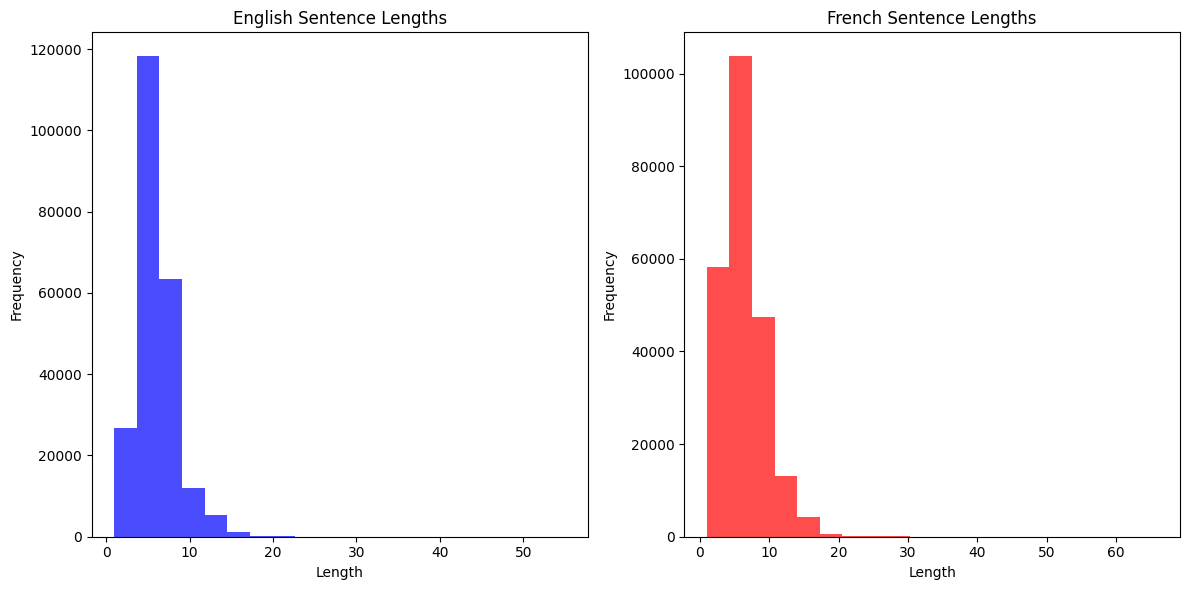

In [7]:
# Calculate sentence lengths
english_lengths = [len(sentence.split()) for sentence in english_sentences]
french_lengths = [len(sentence.split()) for sentence in french_sentences]

# Create histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(english_lengths, bins=20, color='blue', alpha=0.7)
plt.title('English Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(french_lengths, bins=20, color='red', alpha=0.7)
plt.title('French Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.
Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.
Prepare tokenizers for both the French and English sentences

In [8]:
from keras.preprocessing.text import Tokenizer

# Initialize tokenizers for English and French
english_tokenizer = Tokenizer()
french_tokenizer = Tokenizer()

# Fit tokenizers on the preprocessed sentences
english_tokenizer.fit_on_texts(english_sentences)
french_tokenizer.fit_on_texts(french_sentences)

# Convert sentences to sequences of numerical values
english_sequences = english_tokenizer.texts_to_sequences(english_sentences)
french_sequences = french_tokenizer.texts_to_sequences(french_sentences)

# Example: Print the first sentence and its numerical representation
print("Original English Sentence:", english_sentences[0])
print("Numerical Representation:", english_sequences[0])


Original English Sentence: go
Numerical Representation: [43]


We tokenized the data — i.e., converted the text to numerical values. This allows the neural network to perform operations on the input data.
When we run the tokenizer, it creates a word index, which is then used to convert each sentence to a vector.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum sequence length you want
max_sequence_length = 50  # You can adjust this to your desired maximum length

# Pad the sequences to the specified maximum length
padded_english_sequences = pad_sequences(english_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
padded_french_sequences = pad_sequences(french_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Example: Print the first padded sentence and its shape
print("Padded English Sentence:")
print(padded_english_sequences[0])
print("Shape:", padded_english_sequences[0].shape)

print("\nPadded French Sentence:")
print(padded_french_sequences[0])
print("Shape:", padded_french_sequences[0].shape)


Padded English Sentence:
[43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Shape: (50,)

Padded French Sentence:
[99  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Shape: (50,)


When we feed our sequences of word IDs into the model, each sequence needs to be the same length. To achieve this, padding is added to any sequence that is shorter than the max length (i.e. shorter than the longest sentence).


### Model Building

First, let’s breakdown the architecture of an RNN at a high level. Referring to the diagram above, there are a few parts of the model we to be aware of:

Inputs. Input sequences are fed into the model with one word for every time step. Each word is encoded as a unique integer so that it maps to the English dataset vocabulary.
Embedding Layers. Embeddings are used to convert each word to a vector. The size of the vector depends on the complexity of the vocabulary.
LSTM Layer (Encoder). This is where the context from word vectors in previous time steps is applied to the current word vector.
Dense Layers (Decoder). These are typical fully connected layers used to decode the encoded input into the correct translation sequence.
he outputs are returned as a sequence of integers or one-hot encoded vectors which can then be mapped to the French dataset vocabulary.

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
import numpy as np

# Load pre-trained GloVe embeddings
glove_embeddings = {}
embedding_dim = 100  # Adjust this to match the dimension of your chosen GloVe embeddings

with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

# Define the model
model = Sequential()

# Vocabulary size for English input
input_vocab_size = len(english_tokenizer.word_index) + 1  # Vocabulary size + 1 for padding

# Create an embedding matrix for your vocabulary
embedding_matrix = np.zeros((input_vocab_size, embedding_dim))

for word, i in english_tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Use the Embedding layer with pre-trained GloVe embeddings
model.add(Embedding(input_vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

# LSTM encoder layer
encoder_units = 512  # Adjust as needed
model.add(LSTM(encoder_units))

# RepeatVector layer for connecting encoder and decoder
model.add(RepeatVector(max_sequence_length))

# LSTM decoder layer
decoder_units = 512  # Adjust as needed
model.add(LSTM(decoder_units, return_sequences=True))

# Dense output layer
output_vocab_size = len(french_tokenizer.word_index) + 1  # Vocabulary size + 1 for padding
model.add(Dense(output_vocab_size, activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1675100   
                                                                 
 lstm (LSTM)                 (None, 512)               1255424   
                                                                 
 repeat_vector (RepeatVector  (None, 50, 512)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 50, 512)           2099200   
                                                                 
 dense (Dense)               (None, 50, 38463)         19731519  
                                                                 
Total params: 24,761,243
Trainable params: 23,086,143
Non-trainable params: 1,675,100
____________________________________

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    padded_english_sequences, padded_french_sequences, test_size=0.2, random_state=42)

# Define batch size and number of epochs
batch_size = 64
epochs = 10

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(x_test, y_test))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions on unseen data
unseen_data = ["Duck", "I am Tom."]
sentence = [french_tokenizer.index_word[word_idx] for word_idx in seq if word_idx != 0]

# Tokenize and preprocess the unseen data
unseen_sequences = [preprocess_sentence(sentence) for sentence in unseen_data]
unseen_sequences = english_tokenizer.texts_to_sequences(unseen_sequences)
padded_unseen_sequences = pad_sequences(unseen_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Make predictions using the trained model
predicted_sequences = model.predict(padded_unseen_sequences)

# Convert predicted sequences back to text
predicted_sentences = []

for seq in predicted_sequences:
    sentence = []
    for word_idx in seq:
        if word_idx != 0:
            word = french_tokenizer.index_word.get(word_idx)
            if word:
                sentence.append(word)
    predicted_sentences.append(' '.join(sentence))


# Print the translated sentences
for i, sentence in enumerate(predicted_sentences):
    print(f"Input: {unseen_data[i]}")
    print(f"Translation: {sentence}\n")


Epoch 1/10
2848/2848 [==============================] - 590s 205ms/step - loss: 0.9719 - accuracy: 0.8767 - val_loss: 0.9362 - val_accuracy: 0.8772
Epoch 2/10
2848/2848 [==============================] - 635s 223ms/step - loss: 0.9313 - accuracy: 0.8772 - val_loss: 0.9314 - val_accuracy: 0.8772
Epoch 3/10
2848/2848 [==============================] - 580s 204ms/step - loss: 0.9280 - accuracy: 0.8772 - val_loss: 0.9299 - val_accuracy: 0.8772
Epoch 4/10
2848/2848 [==============================] - 635s 223ms/step - loss: 0.9258 - accuracy: 0.8772 - val_loss: 0.9318 - val_accuracy: 0.8769
Epoch 5/10
2848/2848 [==============================] - 635s 223ms/step - loss: 0.9242 - accuracy: 0.8772 - val_loss: 0.9276 - val_accuracy: 0.8772
Epoch 6/10
2848/2848 [==============================] - 582s 204ms/step - loss: 0.9231 - accuracy: 0.8772 - val_loss: 0.9276 - val_accuracy: 0.8769
Epoch 7/10
2848/2848 [==============================] - 635s 223ms/step - loss: 0.9222 - accuracy: 0.8772 - val_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2848/2848 [==============================] - 634s 223ms/step - loss: 0.9208 - accuracy: 0.8772 - val_loss: 0.9274 - val_accuracy: 0.8768
Epoch 10/10
1424/1424 [==============================] - 150s 105ms/step - loss: 0.9253 - accuracy: 0.8772
